## Задача проекта 
Владелец парка аттракционов "Прямовнебо" просит нас проанализировать эмоции людей на одном из его главных развлекательных объектов "Катапульта". Из-за недавно произведенных технико-корректировочных работ, люди стали меньше посещать аттракцион. По мнению владельца, связано это может быть с тем, что людям стало слишком страшно, а должно быть весело.

Необходимо разработать модель машинного обучения, для анализа эмоций людей во время аттракциона. Данные нужно взять из видеокамеры, установленной в кабинке аттракциона. 

## Структура проекта:

* Импорт библиотек
* Загрузка данных
* Создание нейронной сети
* Сохранение модели
* Оценка модели
* Transfer learning (ResNet50)
* Оценка модели ResNet50
* Классификация изображений
* Классификация видео
* Выводы

## Импортируем библиотеки

In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab.patches import cv2_imshow
import zipfile
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Input, GlobalAveragePooling2D
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

## Загрузим изображения

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/data/emotions_2.zip'
zip_object = zipfile.ZipFile(file=path, mode='r')
zip_object.extractall('./')
zip_object.close()

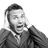

In [ ]:
tf.keras.preprocessing.image.load_img('/content/train/Fear/3.jpg')

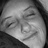

In [ ]:
image = tf.keras.preprocessing.image.load_img('/content/train/Happy/3.jpg')
image

У нас очень небольшие изображения 48*48 пикселей, возможно, при обучении могут возникнуть трудности

In [ ]:
image.size

(48, 48)

### Тренировочная и тестовая выборка

чтобы улучшить обучение модели, инвертируем изображение по горизонтали, сделаем зум и повернем в генераторе

In [ ]:
training_generator = ImageDataGenerator(rescale=1./255,
                                        rotation_range=7,
                                        horizontal_flip=True,
                                        zoom_range=0.2)
train_dataset = training_generator.flow_from_directory('/content/train',
                                                        target_size = (48, 48),
                                                        batch_size = 16,
                                                        class_mode = 'categorical',
                                                        shuffle = True)

Found 11312 images belonging to 2 classes.


In [ ]:
train_dataset.classes

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [ ]:
np.unique(train_dataset.classes, return_counts=False)

array([0, 1], dtype=int32)

У нас 2 класса. Поскольку кроме страха и радости человек редко испытывает другие эмоции во время развлекательных аттракционов, мы будем обучать нашу модель бинарной классификации.

In [ ]:
train_dataset.class_indices

{'Fear': 0, 'Happy': 1}

Посмотрим на распределение классов

Наибольшее количество примеров в тренировочном датасете у эмоции "Радость"

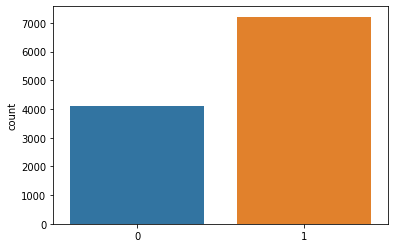

In [ ]:
sns.countplot(x = train_dataset.classes);

In [ ]:
test_generator = ImageDataGenerator(rescale=1./255)
test_dataset = test_generator.flow_from_directory('/content/validation',
                                                  target_size = (48, 48),
                                                  batch_size = 1,
                                                  class_mode = 'categorical',
                                                  shuffle = False)

Found 1407 images belonging to 2 classes.


## Построим нейронную сеть

Для обучения модели будем использовать датасет fer2013: https://www.kaggle.com/msambare/fer2013

Стром сверточную НН. Добавим в сеть Dropout, чтобы избежать переобучения и BatchNormalization для ускорения процессов. В качестве функции активации поставим relu чтобы избежать затухания градиента и фильтр MaxPooling для выбора самый ярких пикселей в ядре. Отступы в сверточном слое заполним нулями "same", чтобы избежать потери информации. Метрикой качества поставим Accuracy. Adam в качестве оптимизатора градиентного спуска и learning rate оставим стандартным.

In [ ]:
num_detectors = 32
num_classes = 2
width, height = 48, 48

network = Sequential()

network.add(Conv2D(num_detectors, (3,3), activation='relu', padding = 'same', input_shape = (width, height, 3)))
network.add(BatchNormalization())
network.add(Conv2D(num_detectors, (3,3), activation='relu', padding = 'same'))
network.add(BatchNormalization())
network.add(MaxPooling2D(pool_size=(2,2)))
network.add(Dropout(0.2))

network.add(Conv2D(2*num_detectors, (3,3), activation='relu', padding = 'same'))
network.add(BatchNormalization())
network.add(Conv2D(2*num_detectors, (3,3), activation='relu', padding = 'same'))
network.add(BatchNormalization())
network.add(MaxPooling2D(pool_size=(2,2)))
network.add(Dropout(0.2))

network.add(Conv2D(2*2*num_detectors, (3,3), activation='relu', padding = 'same'))
network.add(BatchNormalization())
network.add(Conv2D(2*2*num_detectors, (3,3), activation='relu', padding = 'same'))
network.add(BatchNormalization())
network.add(MaxPooling2D(pool_size=(2,2)))
network.add(Dropout(0.2))

network.add(Conv2D(2*2*2*num_detectors, (3,3), activation='relu', padding = 'same'))
network.add(BatchNormalization())
network.add(Conv2D(2*2*2*num_detectors, (3,3), activation='relu', padding = 'same'))
network.add(BatchNormalization())
network.add(MaxPooling2D(pool_size=(2,2)))
network.add(Dropout(0.2))

network.add(Flatten())

network.add(Dense(2 * num_detectors, activation='relu'))
network.add(BatchNormalization())
network.add(Dropout(0.2))

network.add(Dense(2 * num_detectors, activation='relu'))
network.add(BatchNormalization())
network.add(Dropout(0.2))

network.add(Dense(num_classes, activation='softmax'))
print(network.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 48, 48, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 32)       0         
 )                                                               
                                                        

In [ ]:
network.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

Обучим модель на 100 эпохах

In [ ]:
network.fit(train_dataset, epochs=100)

Epoch 1/100
707/707 [==============================] - 38s 36ms/step - loss: 0.7045 - accuracy: 0.6129
Epoch 2/100
707/707 [==============================] - 25s 36ms/step - loss: 0.5515 - accuracy: 0.7208
Epoch 3/100
707/707 [==============================] - 25s 36ms/step - loss: 0.4566 - accuracy: 0.7852
Epoch 4/100
707/707 [==============================] - 26s 36ms/step - loss: 0.4024 - accuracy: 0.8192
Epoch 5/100
707/707 [==============================] - 26s 37ms/step - loss: 0.3669 - accuracy: 0.8413
Epoch 6/100
707/707 [==============================] - 27s 38ms/step - loss: 0.3412 - accuracy: 0.8525
Epoch 7/100
707/707 [==============================] - 26s 37ms/step - loss: 0.3415 - accuracy: 0.8532
Epoch 8/100
707/707 [==============================] - 26s 36ms/step - loss: 0.3171 - accuracy: 0.8649
Epoch 9/100
707/707 [==============================] - 26s 36ms/step - loss: 0.3081 - accuracy: 0.8700
Epoch 10/100
707/707 [==============================] - 26s 36ms/step - l

## Сохраним модель

In [ ]:
network.save("/content/drive/MyDrive/Colab Notebooks/CV/saved_model_emotions")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/CV/saved_model_emotions/assets


In [ ]:
network_loaded = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/CV/saved_model_emotions")


## Оценка модели

Качество на тестовой выборке 94%

In [ ]:
network_loaded.evaluate(test_dataset)

1407/1407 [==============================] - 12s 8ms/step - loss: 0.2126 - accuracy: 0.9403


[0.2126331925392151, 0.9402984976768494]

In [ ]:
network_loaded.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 48, 48, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 32)       0         
 )                                                               
                                                        

Определим предсказания на тестовом датасете

In [ ]:
predictions = network_loaded.predict(test_dataset)
predictions

array([[9.9953461e-01, 4.6536230e-04],
       [9.9727160e-01, 2.7283342e-03],
       [9.9867851e-01, 1.3215069e-03],
       ...,
       [7.2120492e-06, 9.9999285e-01],
       [2.2228997e-08, 1.0000000e+00],
       [2.7592472e-05, 9.9997246e-01]], dtype=float32)

Определим классы предсказаний

In [ ]:
predictions = np.argmax(predictions, axis = 1)
predictions

array([0, 0, 0, ..., 1, 1, 1])

In [ ]:
test_dataset.classes

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [ ]:
len(predictions), len(test_dataset.classes)

(1407, 1407)

In [ ]:
accuracy_score(test_dataset.classes, predictions)

0.9402985074626866

In [ ]:
test_dataset.class_indices

{'Fear': 0, 'Happy': 1}

Построим матрицу ошибок

In [ ]:
cm = confusion_matrix(test_dataset.classes, predictions)
cm

array([[507,  21],
       [ 63, 816]])

Модель ошиблась 84 раза

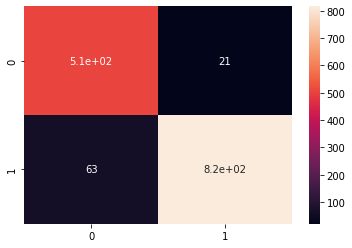

In [ ]:
sns.heatmap(cm, annot=True);

Наибольшее несоответствие класса "Страх" - точность 89%

In [ ]:
print(classification_report(test_dataset.classes, predictions))

              precision    recall  f1-score   support

           0       0.89      0.96      0.92       528
           1       0.97      0.93      0.95       879

    accuracy                           0.94      1407
   macro avg       0.93      0.94      0.94      1407
weighted avg       0.94      0.94      0.94      1407



## Transfer Learning

Сравним наши результаты с предобученной ResNet50.

In [ ]:
base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False,
                                            input_tensor = Input(shape = (48, 48, 3)))

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 54, 54, 3)    0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 24, 24, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 24, 24, 64)   256         ['conv1_conv[0][0]']             
                                                                                           

Всего 175 слоев

In [ ]:
len(base_model.layers)

175

Посмотрим качество на базовой модели, пока ничего размораживать не будем

In [ ]:
for layer in base_model.layers:
  layer.trainable = False

In [ ]:
for layer in base_model.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7fa4b74b7590> False
<keras.layers.convolutional.ZeroPadding2D object at 0x7fa4bf59aa50> False
<keras.layers.convolutional.Conv2D object at 0x7fa4b74b2450> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fa4bf59aa10> False
<keras.layers.core.activation.Activation object at 0x7fa4b74c8910> False
<keras.layers.convolutional.ZeroPadding2D object at 0x7fa4b7c84450> False
<keras.layers.pooling.MaxPooling2D object at 0x7fa4b7a09410> False
<keras.layers.convolutional.Conv2D object at 0x7fa4b799c050> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fa4b799e7d0> False
<keras.layers.core.activation.Activation object at 0x7fa4b799ec50> False
<keras.layers.convolutional.Conv2D object at 0x7fa4b79aee90> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fa4b79b6210> False
<keras.layers.core.activation.Activation object at 0x7fa4b79bc490> False

Прикрепим выходной слой

In [ ]:
base_model.output

<KerasTensor: shape=(None, 2, 2, 2048) dtype=float32 (created by layer 'conv5_block3_out')>

In [ ]:
head_model = base_model.output
head_model = GlobalAveragePooling2D()(head_model)
head_model = Dense(units = 1025, activation='relu')(head_model)
head_model = Dropout(rate = 0.2)(head_model)
head_model = Dense(units = 1025, activation='relu')(head_model)
head_model = Dropout(rate = 0.2)(head_model)
head_model = Dense(2, activation='softmax')(head_model)

Входной слой

In [ ]:
base_model.input

<KerasTensor: shape=(None, 48, 48, 3) dtype=float32 (created by layer 'input_1')>

In [ ]:
network = Model(inputs = base_model.input, outputs = head_model)

In [ ]:
network.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 54, 54, 3)    0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 24, 24, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 24, 24, 64)   256         ['conv1_conv[0][0]']             
                                                                                              

Метрика качества, функция потерь, оптимизатор градиента - все то же, что и в предыдущей модели

In [ ]:
network.compile(optimizer='Adam', loss = 'categorical_crossentropy', metrics=['accuracy'])

Обучаем сеть

In [ ]:
history = network.fit(train_dataset, epochs=10)

Epoch 1/10
707/707 [==============================] - 40s 37ms/step - loss: 0.6722 - accuracy: 0.6300
Epoch 2/10
707/707 [==============================] - 25s 36ms/step - loss: 0.6495 - accuracy: 0.6353
Epoch 3/10
707/707 [==============================] - 26s 37ms/step - loss: 0.6442 - accuracy: 0.6379
Epoch 4/10
707/707 [==============================] - 26s 36ms/step - loss: 0.6480 - accuracy: 0.6378
Epoch 5/10
707/707 [==============================] - 26s 36ms/step - loss: 0.6383 - accuracy: 0.6373
Epoch 6/10
707/707 [==============================] - 26s 36ms/step - loss: 0.6412 - accuracy: 0.6372
Epoch 7/10
707/707 [==============================] - 26s 36ms/step - loss: 0.6363 - accuracy: 0.6378
Epoch 8/10
707/707 [==============================] - 26s 37ms/step - loss: 0.6371 - accuracy: 0.6378
Epoch 9/10
707/707 [==============================] - 26s 37ms/step - loss: 0.6362 - accuracy: 0.6379
Epoch 10/10
707/707 [==============================] - 26s 37ms/step - loss: 0.640

Обучение вышло на плато, дальше учить смысла нет

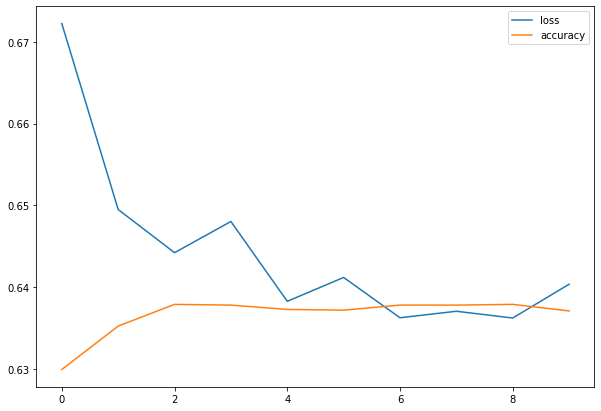

In [ ]:
pd.DataFrame(history.history).plot(figsize=(10, 7));

Результат на предобученной модели без размороженных слоев 62%

In [ ]:
network.evaluate(test_dataset)

1407/1407 [==============================] - 39s 27ms/step - loss: 0.6617 - accuracy: 0.6247


[0.6617065072059631, 0.6247334480285645]

Попробуем улучшить результат. Разморозим все слои.

In [ ]:
base_model.trainable = True

In [ ]:
for layer in base_model.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7fa4b74b7590> True
<keras.layers.convolutional.ZeroPadding2D object at 0x7fa4bf59aa50> True
<keras.layers.convolutional.Conv2D object at 0x7fa4b74b2450> True
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fa4bf59aa10> True
<keras.layers.core.activation.Activation object at 0x7fa4b74c8910> True
<keras.layers.convolutional.ZeroPadding2D object at 0x7fa4b7c84450> True
<keras.layers.pooling.MaxPooling2D object at 0x7fa4b7a09410> True
<keras.layers.convolutional.Conv2D object at 0x7fa4b799c050> True
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fa4b799e7d0> True
<keras.layers.core.activation.Activation object at 0x7fa4b799ec50> True
<keras.layers.convolutional.Conv2D object at 0x7fa4b79aee90> True
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fa4b79b6210> True
<keras.layers.core.activation.Activation object at 0x7fa4b79bc490> True
<keras.layer

In [ ]:
len(base_model.layers)

175

In [ ]:
fine_tuning_at = 140

Заморозим 140 слоев, 35 слоев оставим для тренировки

In [ ]:
for layer in base_model.layers[:fine_tuning_at]:
  layer.trainable = False

In [ ]:
network.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

Натренируем модель на 100 эпохах

In [ ]:
history = network.fit(train_dataset, epochs=100)

Epoch 1/100
707/707 [==============================] - 50s 61ms/step - loss: 0.6322 - accuracy: 0.6478
Epoch 2/100
707/707 [==============================] - 43s 61ms/step - loss: 0.5862 - accuracy: 0.6913
Epoch 3/100
707/707 [==============================] - 43s 61ms/step - loss: 0.5725 - accuracy: 0.7039
Epoch 4/100
707/707 [==============================] - 43s 61ms/step - loss: 0.5524 - accuracy: 0.7192
Epoch 5/100
707/707 [==============================] - 43s 61ms/step - loss: 0.5499 - accuracy: 0.7221
Epoch 6/100
707/707 [==============================] - 43s 61ms/step - loss: 0.5444 - accuracy: 0.7214
Epoch 7/100
707/707 [==============================] - 43s 61ms/step - loss: 0.5493 - accuracy: 0.7221
Epoch 8/100
707/707 [==============================] - 43s 61ms/step - loss: 0.5387 - accuracy: 0.7290
Epoch 9/100
707/707 [==============================] - 43s 61ms/step - loss: 0.5344 - accuracy: 0.7372
Epoch 10/100
707/707 [==============================] - 43s 61ms/step - l

Обучение происходило медленно и нехотя. 76% accuracy на тренировочной выборке

График планомерный. При уменьшении loss, увеличивается accuracy

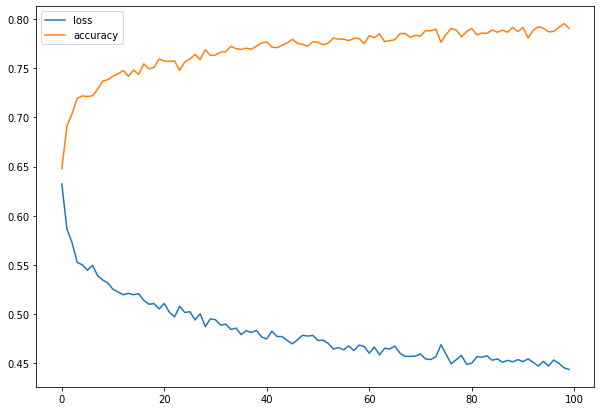

In [ ]:
pd.DataFrame(history.history).plot(figsize=(10, 7));

Протестируем модель. Из реультата 64% на тестовой выбоке при 100 эпохах видно, что переобучилась и плохо воспринимает данный датасет. В работу однозначно беререм первую архитектуру нейронной сети.

In [ ]:
network.evaluate(test_dataset)

1407/1407 [==============================] - 31s 21ms/step - loss: 0.6837 - accuracy: 0.6418


[0.6836893558502197, 0.641791045665741]

In [ ]:
network.save("/content/drive/MyDrive/Colab Notebooks/CV/saved_model_resnet50_emotions")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/CV/saved_model_resnet50_emotions/assets


In [ ]:
network_loaded_resnet50 = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/CV/saved_model_resnet50_emotions")

## Классификация изображения

Ссылка на фото: https://instapie.biz/interesnoe/pochemu-pauki-ne-nasekomye-i-chem-oni-polezny/


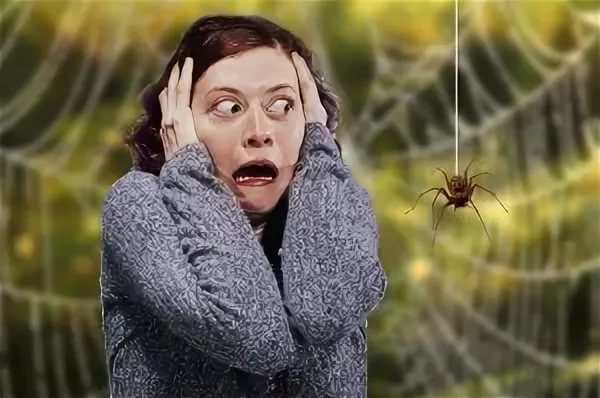

In [ ]:
image = cv2.imread('/content/drive/MyDrive/data/faces/fear_1.jfif')
cv2_imshow(image)

In [ ]:
image.shape

(398, 600, 3)

Загружаем предобученный классификатор по поиску лица

In [ ]:
face_detector = cv2.CascadeClassifier('/content/drive/MyDrive/data/Cascades/haarcascade_frontalface_default.xml')

In [ ]:
original_image = image.copy()
face = face_detector.detectMultiScale(original_image)

In [ ]:
face

array([[184,  45, 146, 146],
       [434, 249,  54,  54]], dtype=int32)

Формируем регион поиска

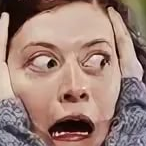

In [ ]:
roi = image[45:45 + 146, 184:184 + 146]
cv2_imshow(roi)

In [ ]:
roi.shape

(146, 146, 3)

Уменьшаем регион но 48*48 пикселей

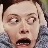

In [ ]:
roi = cv2.resize(roi, (48, 48))
cv2_imshow(roi)

In [ ]:
roi.shape

(48, 48, 3)

In [ ]:
roi

array([[[ 21,  23,  34],
        [ 15,   9,  20],
        [ 15,   9,  20],
        ...,
        [ 81, 129, 133],
        [ 58, 110, 113],
        [ 40,  96,  97]],

       [[ 10,  15,  30],
        [ 15,  17,  28],
        [  8,  10,  21],
        ...,
        [ 91, 139, 140],
        [ 65, 115, 115],
        [ 46,  99,  96]],

       [[  5,  10,  25],
        [ 16,  19,  33],
        [  3,   6,  20],
        ...,
        [ 97, 141, 142],
        [ 77, 123, 124],
        [ 51, 100,  98]],

       ...,

       [[156, 144, 144],
        [130, 118, 118],
        [177, 165, 165],
        ...,
        [152, 132, 137],
        [138, 118, 123],
        [185, 166, 169]],

       [[ 95,  81,  82],
        [171, 157, 158],
        [157, 145, 146],
        ...,
        [215, 195, 200],
        [ 77,  57,  62],
        [172, 153, 156]],

       [[131, 115, 116],
        [146, 132, 133],
        [172, 158, 159],
        ...,
        [109,  89,  94],
        [216, 196, 201],
        [143, 124, 127]]

нормализуем изображение

In [ ]:
roi = roi / 255
roi

array([[[0.08235294, 0.09019608, 0.13333333],
        [0.05882353, 0.03529412, 0.07843137],
        [0.05882353, 0.03529412, 0.07843137],
        ...,
        [0.31764706, 0.50588235, 0.52156863],
        [0.22745098, 0.43137255, 0.44313725],
        [0.15686275, 0.37647059, 0.38039216]],

       [[0.03921569, 0.05882353, 0.11764706],
        [0.05882353, 0.06666667, 0.10980392],
        [0.03137255, 0.03921569, 0.08235294],
        ...,
        [0.35686275, 0.54509804, 0.54901961],
        [0.25490196, 0.45098039, 0.45098039],
        [0.18039216, 0.38823529, 0.37647059]],

       [[0.01960784, 0.03921569, 0.09803922],
        [0.0627451 , 0.0745098 , 0.12941176],
        [0.01176471, 0.02352941, 0.07843137],
        ...,
        [0.38039216, 0.55294118, 0.55686275],
        [0.30196078, 0.48235294, 0.48627451],
        [0.2       , 0.39215686, 0.38431373]],

       ...,

       [[0.61176471, 0.56470588, 0.56470588],
        [0.50980392, 0.4627451 , 0.4627451 ],
        [0.69411765, 0

In [ ]:
roi.shape

(48, 48, 3)

Нужно расширить массив для подачи в модель

In [ ]:
roi = np.expand_dims(roi, axis = 0)
roi.shape

(1, 48, 48, 3)

In [ ]:
probs = network_loaded.predict(roi)
probs

array([[0.9970107 , 0.00298922]], dtype=float32)

Модель с вероятностью 99% определила "Страх"

In [ ]:
result = np.argmax(probs)
result

0

In [ ]:
test_dataset.class_indices

{'Fear': 0, 'Happy': 1}

## Классифицируем множественное фото

Мы тренировали сеть на определение только страха и радости. Посмотрим как она справится с множественным фото и разными эмоциями

Ссылка на фото: https://medium.com/somos-enes/yos-175eed2a4a89

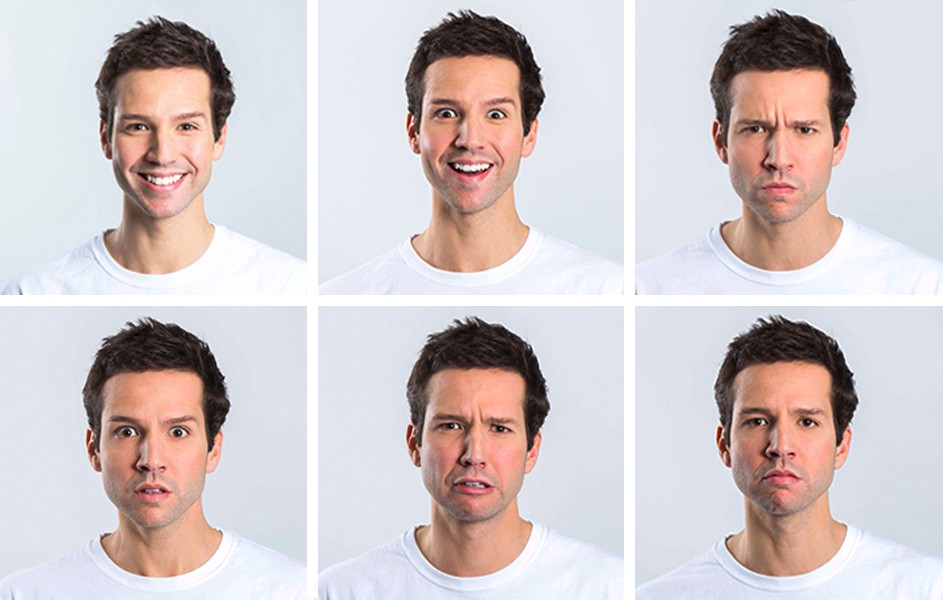

In [ ]:
image = cv2.imread('/content/drive/MyDrive/data/faces/1_50LJ3xyTdAiUvI3DEN_XQA.jpeg')
cv2_imshow(image)

In [ ]:
faces = face_detector.detectMultiScale(image)
faces

array([[401,  57, 140, 140],
       [ 97,  74, 133, 133],
       [712,  77, 134, 134],
       [717, 370, 130, 130],
       [407, 374, 137, 137],
       [ 82, 376, 141, 141]], dtype=int32)

In [ ]:
test_dataset.class_indices.keys()

dict_keys(['Fear', 'Happy'])

In [ ]:
emotions = ['Fear', 'Happy']

Напишем цикл для автоматического определения лицевого региона и идетификации эмоции

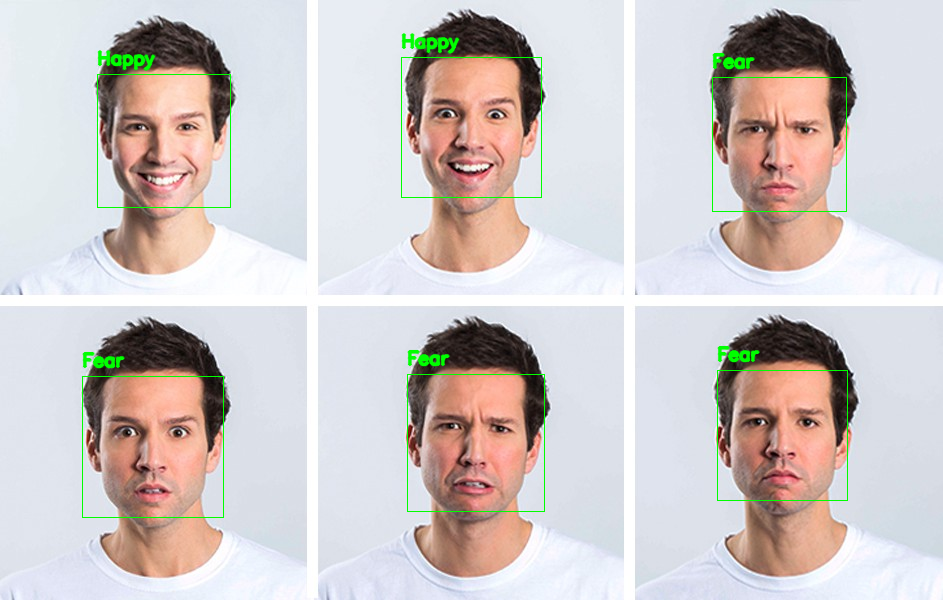

In [ ]:
for (x, y, w, h) in faces:
  cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 1)
  roi = image[y:y + h, x:x + w]
  roi = cv2.resize(roi, (48, 48))
  roi = roi / 255
  roi = np.expand_dims(roi, axis = 0)
  prediction = network_loaded.predict(roi)
  cv2.putText(image, emotions[np.argmax(prediction)], (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,0), 2, cv2.LINE_AA)
cv2_imshow(image)

Учитывая предобученность на 2 классах, сеть справилась очень неплохо: все, что не радость - то страх.

## Классификация эмоций на видео

In [ ]:
cap = cv2.VideoCapture('/content/drive/MyDrive/data/attraction.mp4')
connected, video = cap.read()
print(connected, video.shape)

True (720, 1280, 3)


In [ ]:
save_path = '/content/drive/MyDrive/data/attraction_rezult.mp4'
fourcc = cv2.VideoWriter_fourcc(*'XVID')
fps = 6
output_video = cv2.VideoWriter(save_path, fourcc, fps, (video.shape[1], video.shape[0]))

Источник видеофайла:  https://www.youtube.com/watch?v=CfZqQwc_5-M&list=WL&index=8

In [ ]:
while (cv2.waitKey(1) < 0):
  connected, frame = cap.read()
  if not connected:
    break
  faces = face_detector.detectMultiScale(frame, scaleFactor=1.8, minNeighbors=5, minSize=(30,30))
  if len(faces) > 0:
    for (x, y, w, h) in faces:
      frame = cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
      roi = frame[y:y + h, x:x + w]
      roi = cv2.resize(roi, (48, 48))
      roi = roi / 255
      roi = np.expand_dims(roi, axis = 0)
      prediction = network_loaded.predict(roi)

      if prediction is not None:
        result = np.argmax(prediction)
        cv2.putText(frame, emotions[result], (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1, cv2.LINE_AA)


  
  cv2_imshow(frame)
  output_video.write(frame)

print('End')

output_video.release()
cv2.destroyAllWindows()

Output hidden; open in https://colab.research.google.com to view.

Пример кадра из получившегося видео

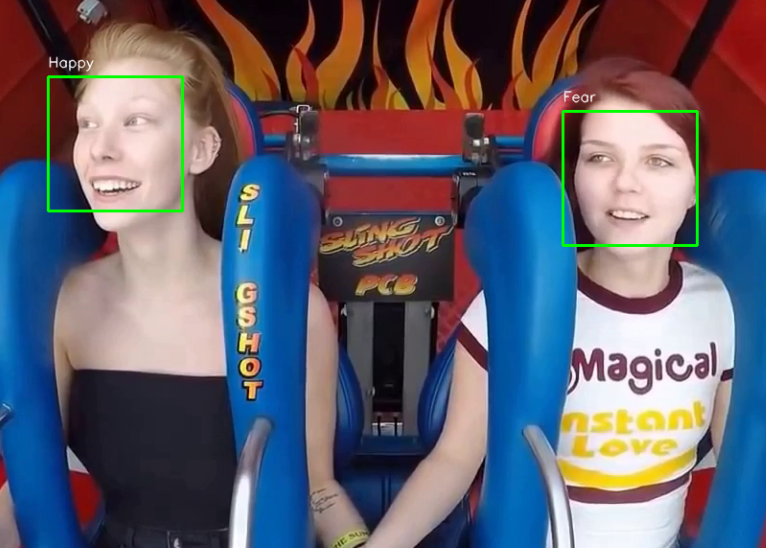

In [3]:
tf.keras.preprocessing.image.load_img('/content/drive/MyDrive/data/faces/emotions-2girls.png')

Ссылка на видео: https://drive.google.com/file/d/1y55IPtQyIx7rYuyDQxe9m_uPErh7IPA3/view?usp=sharing

## Выводы:
В данном проекте для определения страха/счастья была обучена нейронная сеть. На тестовой выборке удалось достичь качества 94%. В качестве сравнения с полученным показателем была взята в работу ResNet50 методом transfer learning, в которой были разморожены и обучены на нашем датасете 35 слоев. После проведения анализа качества ResNet50, было принято решение оставить первоначальную архитектуру нейронной сети с качеством 94%.
Обученная нейронная сеть была успешно использована для классификации единичных фото и видео из аттракциона. Поставленная задача выполнена.  